## Import libraries

In [ ]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

client = ESMC.from_pretrained("esmc_600m").to("cuda")

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
import torch 

## Dataset GFP

In [4]:
# we can create the dataset:
data_dir = Path("/n/home06/tbush/gfp_function_prediction/data/raw_data")
sequence_path =  data_dir / "P42212.fasta.txt"
original_dataset_path = data_dir / "amino_acid_genotypes_to_brightness.tsv"
# load the dataset
gfp_dataset_original = pd.read_csv(original_dataset_path, sep="\t")

In [5]:
# load utilities functions 
from utils.utils import parse_mutation, mutate_seq, get_numb_mut, load_seq_
def mutate_sequence(mutation_string, seq, mapping_db_seq):
    if pd.isna(mutation_string):
        return None
    try:
        mutations = mutation_string.split(":")
        for m in mutations:
            src, idx, dest = parse_mutation(m)
            if idx in mapping_db_seq:
                mapped_idx = mapping_db_seq[idx]
                mutated_seq = seq[:mapped_idx] + dest + seq[mapped_idx + 1 :]
                return mutated_seq
    except Exception:
        return None
    return None

    # Calculate the original distribution of num_mut
    def get_numb_mut(mut: str) -> int:
        if type(mut) == str:
            n = len(mut.split(":"))
        else:
            return 0
        return n

In [6]:
seq, mapping = load_seq_(sequence_path)
gfp_dataset_original["seq_mutated"] = gfp_dataset_original["aaMutations"].apply(
    lambda muts: mutate_sequence(muts, seq=seq, mapping_db_seq=mapping)
)
gfp_dataset_original["num_mut"] = gfp_dataset_original['aaMutations'].apply(lambda mut: get_numb_mut(mut))

## LLR Metric Computation

In [7]:
# now we load the model + utilities for calculuting the LLR metrics
from esm.sdk.api import ESMProtein, LogitsConfig
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [8]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
client = ESMC.from_pretrained("esmc_600m").to("cuda")
def token_id(x: str, client) -> int:
    enc = client.encode(ESMProtein(x))
    return int(enc.sequence[1])  # BOS at 0, your token at 1, EOS at 2
aa_ids = {a: token_id(a, client=client) for a in amino_acids}
mask_id = token_id("<mask>", client=client)

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [9]:
def generate_heatmap(protein_sequence:str, start_pos:int=1, end_pos=None):

  # load model and tokenizer
  forge_client = ESMC.from_pretrained("esmc_600m").to("cuda")
  aa_ids = {'A': 5,
            'C': 23,
            'D': 13,
            'E': 9,
            'F': 18,
            'G': 6,
            'H': 21,
            'I': 12,
            'K': 15,
            'L': 4,
            'M': 20,
            'N': 17,
            'P': 14,
            'Q': 16,
            'R': 10,
            'S': 8,
            'T': 11,
            'V': 7,
            'W': 22,
            'Y': 19}

  # tokenize the input sequence
  protein = ESMProtein(protein_sequence)
  input_ids = forge_client.encode(protein)
  sequence_length = len(protein_sequence)

  if end_pos is None:
    end_pos = sequence_length

  # list aminoacids
  amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

  #initialize the heatmap
  heatmap = np.zeros((20, end_pos - start_pos + 1))

  # calculate LLRs for each position and aminoacid:
  for position in range(start_pos, end_pos +1):
    # make masked sequence
    i = position -1
    masked_seq = protein_sequence[:i] + "<mask>" + protein_sequence[i+1:]
    protein = ESMProtein(masked_seq)
    enc = forge_client.encode(protein)

    # get per-position logits
    out = forge_client.logits(
    enc, LogitsConfig(sequence=True, return_embeddings=True))

    # identify the masked-token index in logits:
    masked_tok_idx = position
    masked_logits = out.logits.sequence.squeeze()[masked_tok_idx]

    # get log probs:
    log_probs = torch.log(F.softmax(masked_logits, dim=-1))

    # wt residue
    wt_residue = protein_sequence[position-1]
    wt_id = aa_ids[wt_residue]
    log_prob_wt = log_probs[wt_id].item()

    # LLR for the residues
    for i, aa in enumerate(amino_acids):
      mt_id = aa_ids[aa]
      log_prob_mt = log_probs[mt_id].item()
      heatmap[i, position-start_pos] = log_prob_mt - log_prob_wt

  # visualize the heatmap
  plt.figure(figsize=(15, 5))
  plt.imshow(heatmap, cmap="viridis", aspect="auto")
  plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
  plt.yticks(range(20), amino_acids)
  plt.xlabel("Position in Protein Sequence")
  plt.ylabel("Amino Acid Mutations")
  plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
  plt.colorbar(label="Log Likelihood Ratio (LLR)")
  plt.show()
  return heatmap


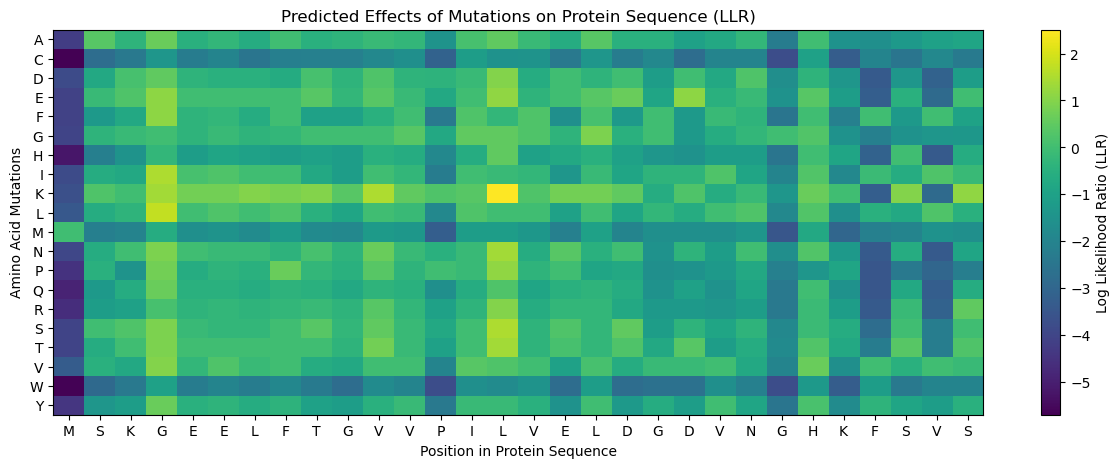

In [10]:
heatmap = generate_heatmap(seq, end_pos=30)

### Function to get embedding and P of a mutated sequence:

In [11]:
def get_embedding(sequence:str, client:ESMC):
    protein = ESMProtein(sequence)
    enc = client.encode(protein)
    out = client.logits(
        enc, LogitsConfig(sequence=True, return_embeddings=True))
    return out.logits.sequence, out.embeddings 

In [12]:
embeddings, logits = get_embedding(seq, client)

### Try to predict the function

In [12]:
# funciton to get embeddings in batch:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Sequence, Tuple, List, Any, Union
from tqdm.auto import tqdm
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

def embed_sequence(client: ESMC, sequence: Union[str, ESMProtein]):
    """Return (logits, embeddings) on CPU. Shapes: (1, L, V), (1, L, D)."""
    protein = sequence if isinstance(sequence, ESMProtein) else ESMProtein(sequence)
    enc = client.encode(protein)
    out = client.logits(enc, LogitsConfig(sequence=True, return_embeddings=True))
    # move to CPU to avoid GPU-memory blowup and ensure cat compatibility
    return out.logits.sequence.detach().to("cpu"), out.embeddings.detach().to("cpu")

# --- batch wrapper (threaded; set max_workers=1 for safest CUDA use) ---
def batch_embed(
    client: ESMC,
    inputs: Sequence[Union[str, ESMProtein]],
    max_workers: int = 1,   # GPU models are often not thread-safe; 1 is safest
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    """
    Runs embed_sequence for each input. Preserves order, returns lists of tensors.
    """
    n = len(inputs)
    logits:     List[Any] = [None] * n
    embeddings: List[Any] = [None] * n

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(embed_sequence, client, seq): i for i, seq in enumerate(inputs)}
        for fut in tqdm(as_completed(futures), total=n, desc="Embedding"):
            i = futures[fut]
            try:
                logit, emb = fut.result()
                logits[i] = logit
                embeddings[i] = emb
            except Exception as e:
                logits[i] = e
                embeddings[i] = e

    # check for errors
    errors = [(i, x) for i, x in enumerate(logits) if isinstance(x, Exception)]
    if errors:
        msgs = "\n".join([f"  idx {i}: {err}" for i, err in errors])
        raise RuntimeError(f"{len(errors)} sequences failed:\n{msgs}")

    # type narrowing
    logits = [t for t in logits if isinstance(t, torch.Tensor)]
    embeddings = [t for t in embeddings if isinstance(t, torch.Tensor)]
    return logits, embeddings

# --- dataset helper ---
def create_dataset(df: pd.DataFrame, n: int, client: ESMC):
    """
    Samples n rows, embeds seq_mutated strings.
    Returns:
      logits_b:     Tensor (N, L, V)
      embeddings_b: Tensor (N, L, D)
      labels_t:     Tensor (N,)
    """
    sampled_df = df.sample(n)  # add random_state=... for reproducibility
    inputs = sampled_df["seq_mutated"].tolist()  # keep as strings
    labels = sampled_df["Class"].tolist()

    logits_list, emb_list = batch_embed(client, inputs, max_workers=1)

    # sanity: all lengths equal
    lengths = [t.shape[1] for t in logits_list]
    if len(set(lengths)) != 1:
        raise ValueError(f"Sequences have different lengths: {set(lengths)}; "
                         "cannot concatenate without padding.")

    # concatenate along the batch dimension (dim=0)
    logits_b = torch.cat(logits_list, dim=0)       # (N, L, V)
    embeddings_b = torch.cat(emb_list, dim=0)      # (N, L, D)
    labels_t = torch.as_tensor(labels)

    return logits_b, embeddings_b, labels_t


In [13]:
# create labels for GoF and LoF: 2.6 is the mean, median 3.2
gfp_dataset_original["Class"] = gfp_dataset_original["medianBrightness"].apply(lambda x: 0 if x <= 2.6 else 1 )

In [14]:
# now let's create a dataset with Pytorch + model
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, n:int, client):
        logits, embeddings, labels = create_dataset(gfp_dataset_original, n, client)
        self.features = embeddings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        embedding = self.features[index]
        label = self.labels[index]
        return embedding, label

In [15]:
dataset = CustomDataset(gfp_dataset_original, 10, client)
WT_L, WT = embed_sequence(client, seq)

Embedding:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# create a simple NN:
import torch
import torch.nn as nn
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe[None])  # (1, max_len, d_model)

    def forward(self, x):  # x: (B, L, D)
        return x + self.pe[:, :x.size(1), :]

class WTMutClassifier(nn.Module):
    """
    Compare mutant (MT) to wildtype (WT) residue-wise and classify sequence (0/1).

    Inputs:
      wt: (1, L, D) or (B, L, D)  wildtype embeddings (broadcast if 1, L, D)
      mt: (B, L, D)               mutant embeddings

    Output:
      logits: (B,)  (use BCEWithLogitsLoss)
    """
    def __init__(self, in_dim=1152, hidden=512, n_layers=2, n_heads=8, dropout=0.1, max_len=256):
        super().__init__()

        # per-residue projection (shared for WT/MT)
        self.norm = nn.LayerNorm(in_dim)
        self.proj = nn.Linear(in_dim, hidden)

        # fuse per-residue pair features into model dim
        # features = [Δ, |Δ|, WT⊙MT]  -> 3*hidden  -> hidden
        self.fuse = nn.Sequential(
            nn.Linear(3 * hidden, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        # transformer over residue deltas
        enc_layer = nn.TransformerEncoderLayer(
            d_model=hidden, nhead=n_heads, dim_feedforward=hidden * 4,
            dropout=dropout, activation="gelu", batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # [CLS] token + positional encoding
        self.cls = nn.Parameter(torch.zeros(1, 1, hidden))
        nn.init.trunc_normal_(self.cls, std=0.02)
        self.posenc = SinusoidalPositionalEncoding(hidden, max_len=max_len + 1)

        self.head = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 1)  # single logit
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, wt, mt, lengths=None):
        """
        wt: (1, L, D) or (B, L, D)
        mt: (B, L, D)
        lengths (optional): (B,) valid lengths if sequences are padded.
        """
        B, L, D = mt.shape
        if wt.shape[0] == 1:
            wt = wt.expand(B, -1, -1)  # broadcast the single WT to the batch

        # project to hidden
        wt_h = self.proj(self.norm(wt))   # (B, L, hidden)
        mt_h = self.proj(self.norm(mt))   # (B, L, hidden)

        # residue-wise pair features
        delta = mt_h - wt_h
        feat = torch.cat([delta, delta.abs(), wt_h * mt_h], dim=-1)  # (B, L, 3*hidden)
        h = self.fuse(feat)  # (B, L, hidden)

        # prepend [CLS] and add positions
        cls = self.cls.expand(B, 1, -1)
        h = torch.cat([cls, h], dim=1)         # (B, L+1, hidden)
        h = self.posenc(h)

        # optional padding mask (True = masked)
        key_padding_mask = None
        if lengths is not None:
            mask_seq = torch.arange(L, device=lengths.device)[None, :].expand(B, L) >= lengths[:, None]
            key_padding_mask = torch.cat([torch.zeros(B, 1, dtype=torch.bool, device=lengths.device),
                                          mask_seq], dim=1)

        # encode and classify
        h = self.encoder(h, src_key_padding_mask=key_padding_mask)
        cls_repr = self.dropout(h[:, 0])
        logits = self.head(cls_repr).squeeze(-1)  # (B,)
        return logits

In [17]:
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
import random
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
writer = SummaryWriter(log_dir="/n/home06/tbush/runs/wtmt_proto")

In [ ]:
def collate_batch(batch):
    embs, labels = zip(*batch)
    x = torch.stack([torch.as_tensor(e, dtype=torch.float32) for e in embs], dim=0)  # (B, L, D)
    y = torch.as_tensor(labels, dtype=torch.float32)  # (B,)
    return x, y

# -------- one epoch --------
def epoch_pass(model, loader, device, WT_t, criterion, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()

    losses, all_probs, all_targets = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(WT_t, x)                     # (B,)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        targets = y.detach().cpu().numpy()

        losses.append(loss.item())
        all_probs.append(probs)
        all_targets.append(targets)

    all_probs = np.concatenate(all_probs) if all_probs else np.array([])
    all_targets = np.concatenate(all_targets) if all_targets else np.array([])
    preds = (all_probs >= 0.5).astype(int) if len(all_probs) else np.array([])
    acc = accuracy_score(all_targets, preds) if len(preds) else float("nan")
    try:
        auc = roc_auc_score(all_targets, all_probs) if len(np.unique(all_targets)) > 1 else float("nan")
    except ValueError:
        auc = float("nan")

    return float(np.mean(losses)), acc, auc, all_probs, all_targets

# -------- training loop --------
def train_prototype(
    df, n, client, WT, in_dim=1152,
    batch_size=32, epochs=20, lr=3e-4, val_split=0.2,
    seed=42, device=None, patience=4,
    log_dir=None,           # e.g., "runs/wtmt_proto" to enable TensorBoard
    curve_every=2           # log ROC/PR every N epochs if TB is on
):
    # Dataset & split
    full_ds = CustomDataset(df, n, client)
    n_total = len(full_ds)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val
    train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(seed))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    # Device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else
                              "mps" if torch.backends.mps.is_available() else "cpu")

    # WT tensor
    WT_t = torch.as_tensor(WT, dtype=torch.float32)
    if WT_t.dim() == 2:
        WT_t = WT_t.unsqueeze(0)  # (1, L, D)
    WT_t = WT_t.to(device)

    # Model
    model = WTMutClassifier(in_dim=in_dim, hidden=512, n_layers=2, n_heads=8, dropout=0.1, max_len=256).to(device)

    # Class weighting (global)
    labels = np.array([full_ds[i][1] for i in range(len(full_ds))])
    n_pos, n_neg = (labels == 1).sum(), (labels == 0).sum()
    pos_weight = torch.tensor(n_neg / max(n_pos, 1), dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # TensorBoard writer (optional)
    writer = SummaryWriter(log_dir=log_dir) if log_dir is not None else None

    # Training loop with early stopping (no checkpoint saving)
    best_auc = -1.0
    patience_left = patience

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc, tr_auc, _, _ = epoch_pass(model, train_loader, device, WT_t, criterion, optimizer)
        va_loss, va_acc, va_auc, va_probs, va_targets = epoch_pass(model, val_loader, device, WT_t, criterion)

        print(f"Epoch {ep:02d} | "
              f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f} | "
              f"val_loss {va_loss:.4f} acc {va_acc:.4f} auc {va_auc:.4f}")

        # --- TensorBoard scalars ---
        if writer is not None:
            writer.add_scalar("Loss/train", tr_loss, ep)
            writer.add_scalar("Loss/val",   va_loss, ep)
            writer.add_scalar("Acc/train",  tr_acc, ep)
            writer.add_scalar("Acc/val",    va_acc, ep)
            writer.add_scalar("AUC/train",  tr_auc, ep)
            writer.add_scalar("AUC/val",    va_auc, ep)

            # Optional curves every few epochs (requires matplotlib)
            if (ep % curve_every == 0) and len(np.unique(va_targets)) > 1:
                # ROC
                fpr, tpr, _ = roc_curve(va_targets, va_probs)
                fig = plt.figure()
                plt.plot(fpr, tpr)
                plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (val) epoch {ep}")
                writer.add_figure("ROC/val", fig, global_step=ep)
                plt.close(fig)

                # PR
                prec, rec, _ = precision_recall_curve(va_targets, va_probs)
                fig = plt.figure()
                plt.plot(rec, prec)
                plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR (val) epoch {ep}")
                writer.add_figure("PR/val", fig, global_step=ep)
                plt.close(fig)

        # --- early stopping on val AUC ---
        if not np.isnan(va_auc) and va_auc > best_auc:
            best_auc = va_auc
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                print(f"Early stopping at epoch {ep}. Best val AUC: {best_auc:.4f}")
                break

    if writer is not None:
        writer.close()

    return model

In [20]:
model = train_prototype(gfp_dataset_original, n=2000, client=client, WT=WT, in_dim=1152, epochs=40, batch_size=64, patience=6)

Embedding:   0%|          | 0/2000 [00:00<?, ?it/s]

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | train_loss 0.6994 acc 0.5225 auc 0.5202 | val_loss 0.7231 acc 0.4175 auc 0.6856
Epoch 02 | train_loss 0.6358 acc 0.5169 auc 0.5364 | val_loss 0.6000 acc 0.6150 auc 0.7154
Epoch 03 | train_loss 0.5699 acc 0.6281 auc 0.6857 | val_loss 0.5253 acc 0.7050 auc 0.7401
Epoch 04 | train_loss 0.5201 acc 0.7056 auc 0.7435 | val_loss 0.5099 acc 0.7275 auc 0.7624
Epoch 05 | train_loss 0.4974 acc 0.7300 auc 0.7702 | val_loss 0.5128 acc 0.7175 auc 0.7794
Epoch 06 | train_loss 0.4769 acc 0.7431 auc 0.7978 | val_loss 0.5313 acc 0.7000 auc 0.7960
Epoch 07 | train_loss 0.4691 acc 0.7419 auc 0.8108 | val_loss 0.4897 acc 0.7300 auc 0.8000
Epoch 08 | train_loss 0.4596 acc 0.7588 auc 0.8218 | val_loss 0.4790 acc 0.7250 auc 0.7993
Epoch 09 | train_loss 0.4307 acc 0.7719 auc 0.8460 | val_loss 0.5102 acc 0.7275 auc 0.8065
Epoch 10 | train_loss 0.4402 acc 0.7556 auc 0.8395 | val_loss 0.4867 acc 0.7150 auc 0.7979
Epoch 11 | train_loss 0.4278 acc 0.7656 auc 0.8493 | val_loss 0.4817 acc 0.7350 auc 0.8130